# Collect Data and Train Gaussian Processes

## Setup and imports

In [1]:
# ===============================================
# 1️⃣ Setup e imports
# ===============================================
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import time, os
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Configuración base de MuJoCo
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

# Función para hacer un paso en la simulación
def step_sim(data, ctrl):
    data.ctrl[:] = ctrl
    mj.mj_step(model, data)
    return np.array([
        data.sensor("pos_drone").data[0],   # x
        data.sensor("pos_drone").data[2],   # z
        data.qvel[0],                       # x'
        data.qvel[2],                       # z'
        data.qpos[1],                       # θ (asumiendo 2° DoF rotacional)
        data.qvel[1],                       # θ'
    ])

print("✅ Simulador inicializado correctamente.")


✅ Simulador inicializado correctamente.


## Data collection

In [3]:
# ===============================================
# 2️⃣ Recolección de datos del simulador
# ===============================================

# Función para "desenvolver" ángulos
def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos, extendiendo más allá de [-π, π].
    """
    if angle_prev is None:
        return angle_raw

    # diferencia cruda
    delta = angle_raw - angle_prev

    # si cruzó el límite, corrige ±2π
    if delta > np.pi:
        angle_raw -= 2*np.pi
    elif delta < -np.pi:
        angle_raw += 2*np.pi

    return angle_raw


# Función para convertir cuaternión a ángulo de pitch (Y)
def quat_to_pitch_y(quat, prev_roll=None):
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None, dt=0.01):
    # --- Posición global ---
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # --- Velocidades lineales del cuerpo (provenientes de MuJoCo) ---
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # --- Cuaternión del dron ---
    quat = data.sensor("quat_drone").data   # [w,x,y,z]

    # --- Roll instantáneo ---
    roll_raw = quat_to_pitch_y(quat)

    # --- Roll continuo con unwrap ---
    if prev_theta is None:
        theta = roll_raw
    else:
        delta = roll_raw - prev_theta
        if delta > np.pi:
            roll_raw -= 2*np.pi
        elif delta < -np.pi:
            roll_raw += 2*np.pi
        theta = roll_raw

    # --- Velocidad angular: eje X = roll ---
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]   # solo el roll

    state = np.array([x, z, x_dot, z_dot, theta, theta_dot])
    return state, theta





def rollout_random(model, data, n_steps=10000, dt=0.01):
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps)):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        # Acción aleatoria
        a_t = np.random.uniform(0.0, step/n_steps*2.0, size=2) # fuerza entre 0 y 2*N, escalada con el tiempo
        data.ctrl[:] = a_t

        # Avanzar simulación
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    return np.array(states), np.array(actions), np.array(next_states)





# Ejecutar recolección
states, actions, next_states = rollout_random(model, data, n_steps=2000, dt=0.01)

# Guardar diferencias (delta_s)
delta_s = next_states - states

print("✅ Datos recolectados:", states.shape, actions.shape, delta_s.shape)


100%|██████████| 2000/2000 [00:00<00:00, 28737.85it/s]

✅ Datos recolectados: (2000, 6) (2000, 2) (2000, 6)


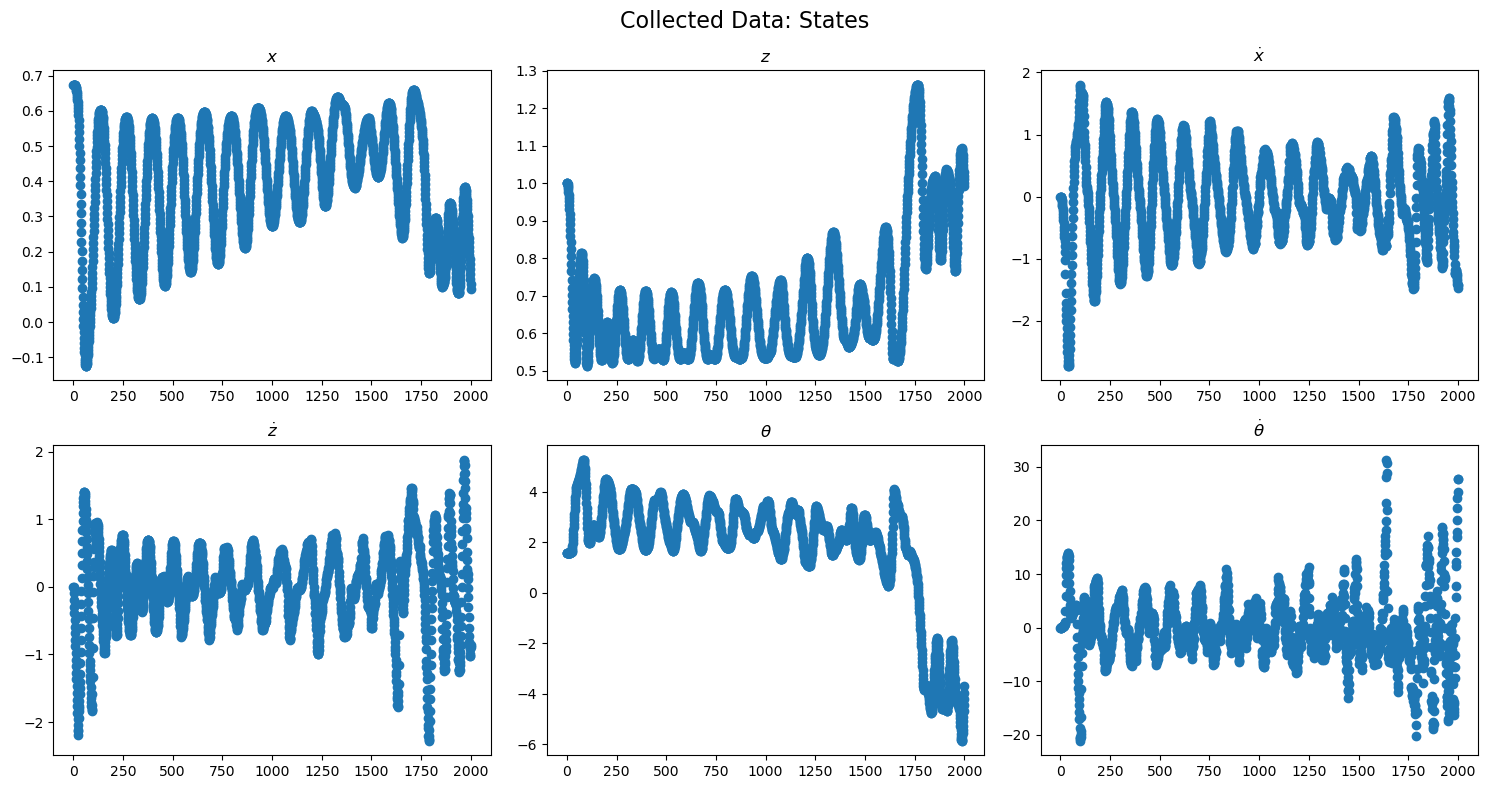

In [4]:
# ===============================================
# 3️⃣ Visualización de los datos recolectados
# ===============================================

rng = 2000
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()



## Gaussian Process Training

In [8]:
# ===============================================
# Imports for GP model
# ===============================================   
import torch
import gpytorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device GP:", device)


# ===============================================
# Build training data for GP model
# ===============================================
# states: (N, 6)
# actions: (N, 2)
# delta_s: (N, 6)

state_dim = states.shape[1]   # 6
act_dim   = actions.shape[1]  # 2
out_dim   = delta_s.shape[1]  # 6

X_full = np.hstack([states, actions])  # (N, 8)
Y_full = delta_s                       # (N, 6)

N = X_full.shape[0]
print("X_full:", X_full.shape, "Y_full:", Y_full.shape)


# ===============================================
# Sample training data for GP model 
# ===============================================
# Número de puntos de entrenamiento para el GP
N_train = 5000   # puedes ajustarlo (2k–10k típico)

idx = np.random.choice(N, size=N_train, replace=False)

X_train_np = X_full[idx]
Y_train_np = Y_full[idx]

print("Train set:", X_train_np.shape, Y_train_np.shape)


# ===============================================
# Normalize training data for GP model
# ===============================================

# Normalización input
X_mean = X_train_np.mean(axis=0, keepdims=True)
X_std  = X_train_np.std(axis=0, keepdims=True) + 1e-8

# Normalización output
Y_mean = Y_train_np.mean(axis=0, keepdims=True)
Y_std  = Y_train_np.std(axis=0, keepdims=True) + 1e-8

X_train_norm = (X_train_np - X_mean) / X_std
Y_train_norm = (Y_train_np - Y_mean) / Y_std

# A tensores en GPU
X_train_t = torch.tensor(X_train_norm, dtype=torch.float32, device=device)  # (Ntrain, 8)
Y_train_t = torch.tensor(Y_train_norm, dtype=torch.float32, device=device)  # (Ntrain, 6)

num_tasks = out_dim  # 6


# ===============================================
# Define and instantiate the GP model
# ===============================================

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            base_mean=gpytorch.means.ConstantMean(),
            num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            ),
            num_tasks=num_tasks,
            rank=1,  # baja dimensión para la correlación entre tareas
        )

    def forward(self, x):
        mean_x = self.mean_module(x)      # (N, num_tasks)
        covar_x = self.covar_module(x)    # multitask kernel
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

model = MultitaskGPModel(X_train_t, Y_train_t, likelihood).to(device)
print(model)


# ===============================================
# Train the GP model
# ===============================================

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100  # ajustable

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train_t)           # MultitaskMultivariateNormal
    loss = -mll(output, Y_train_t)
    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - loss: {loss.item():.4f}")







Device GP: cuda
X_full: (2000, 8) Y_full: (2000, 6)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [4]:
import os, joblib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Crear carpeta si no existe
os.makedirs("data/gp_models", exist_ok=True)

# Entradas = estado + acción   -> (N, 8)
X = np.hstack([states, actions])  # [x, z, ẋ, ż, θ, θ̇, u_left, u_right]
Y = delta_s                       # (N, 6)

# Archivos donde se guardarán los modelos (uno por cada dimensión de delta_s)
model_paths = [f"data/gp_models/gp_model_{i}.pkl" for i in range(Y.shape[1])]

# Kernel compartido
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))

gps = []
all_exist = all(os.path.exists(p) for p in model_paths)

if all_exist:
    print("📂 Cargando modelos GP guardados...")
    for path in model_paths:
        gps.append(joblib.load(path))
    print("✅ Modelos cargados correctamente.")
else:
    print("⚙️ Entrenando nuevos modelos Gaussian Process...")
    for i in tqdm(range(Y.shape[1])):
        gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            n_restarts_optimizer=2,
            random_state=0,
        )
        gp.fit(X, Y[:, i])
        gps.append(gp)
        joblib.dump(gp, model_paths[i])
    print("✅ Entrenamiento y guardado completo.")


📂 Cargando modelos GP guardados...
✅ Modelos cargados correctamente.


## Validation and Visualization

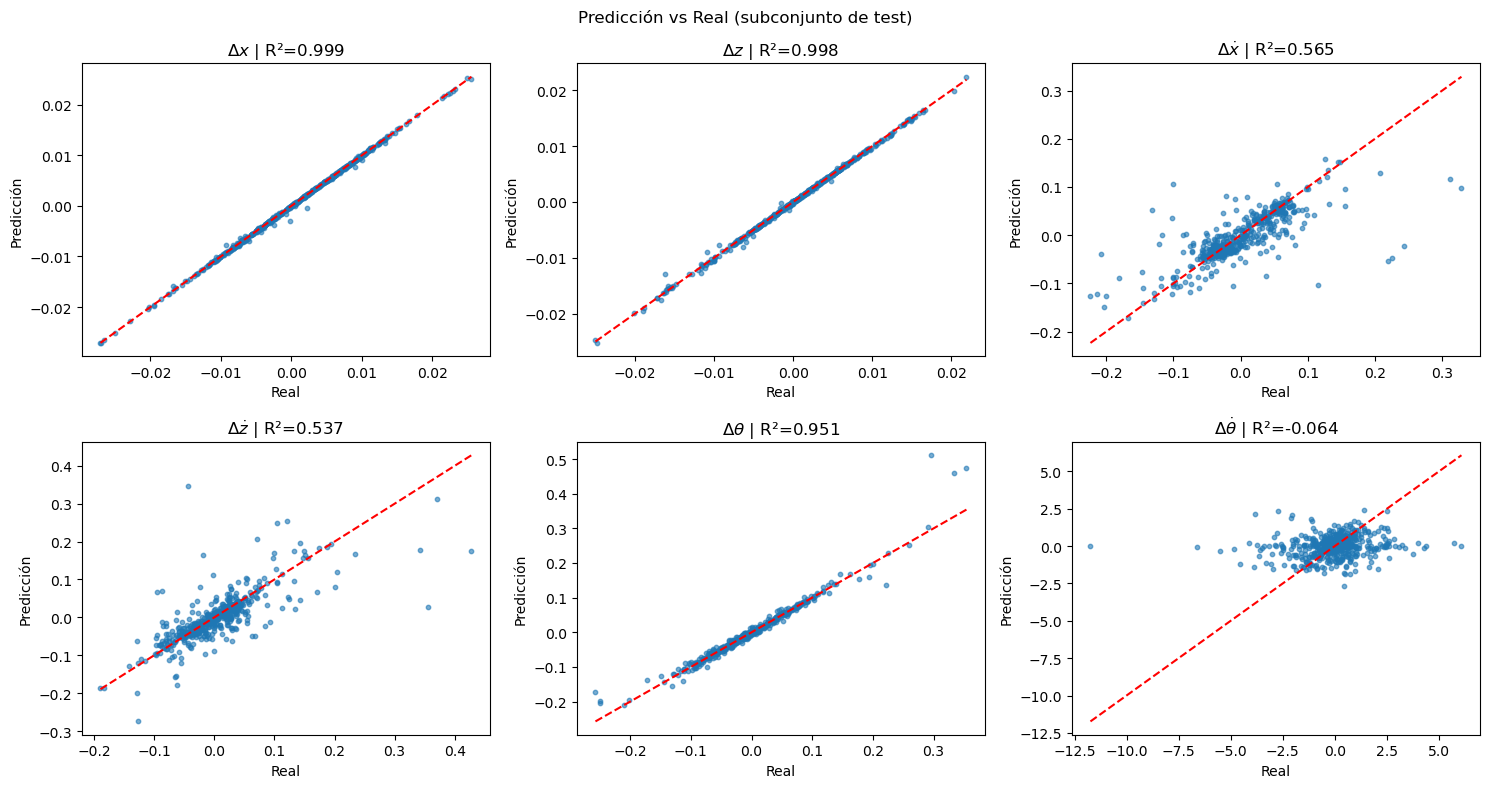

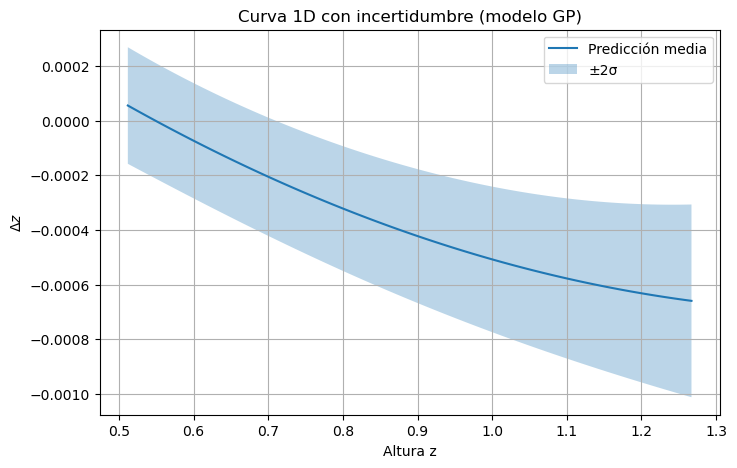

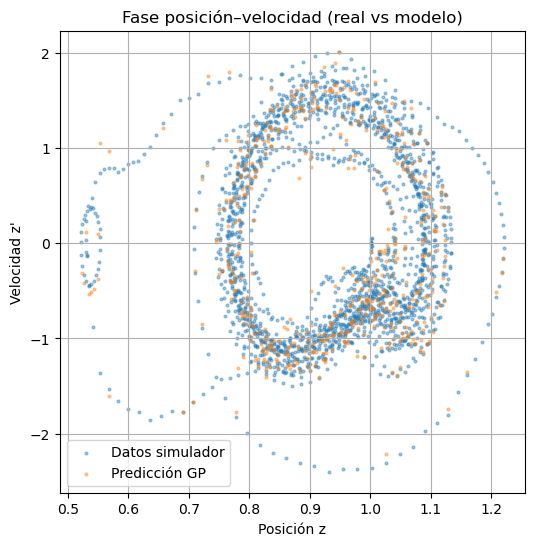

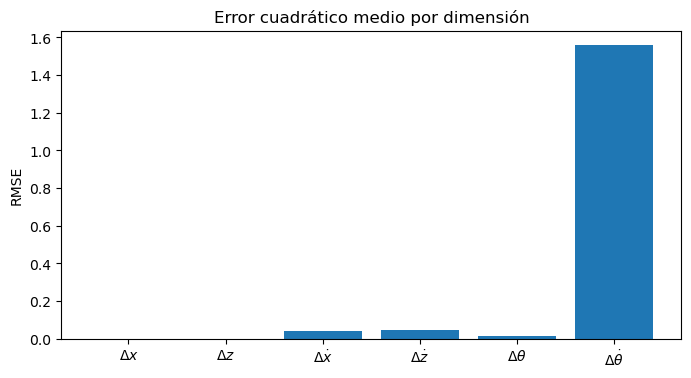

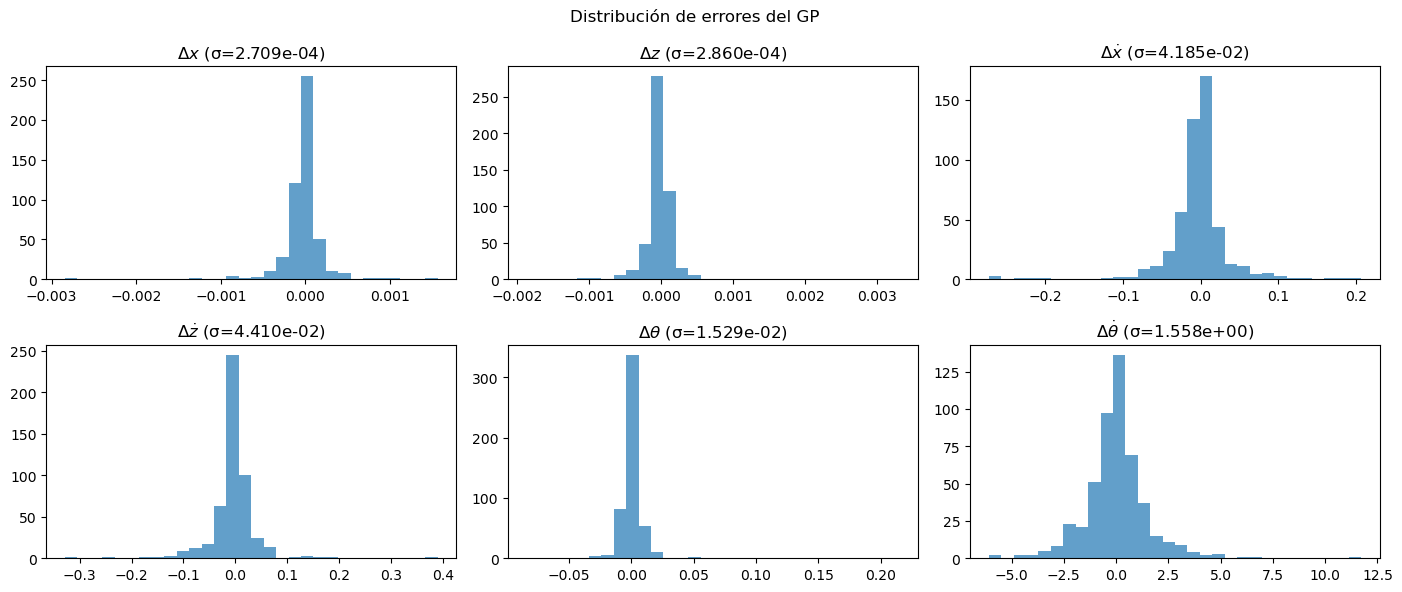

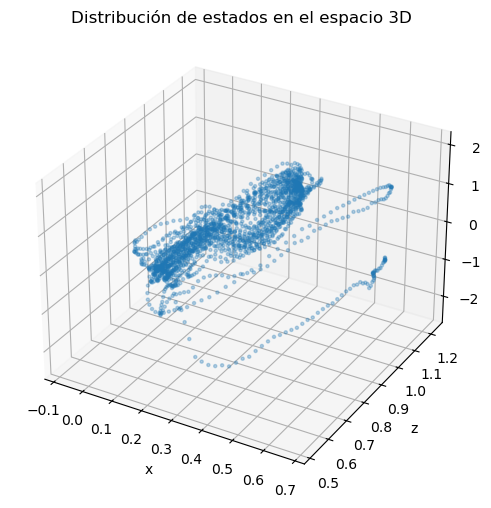

In [83]:
# ===============================================
# 4️⃣ Diagnóstico y visualización del modelo GP
# ===============================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Recalcular predicciones sobre un subconjunto de datos
idx = np.random.choice(len(X), size=500, replace=False)
X_test, Y_true = X[idx], Y[idx]
Y_pred = np.zeros_like(Y_true)

# Predicciones por modelo
for i in range(Y_true.shape[1]):
    Y_pred[:, i] = gps[i].predict(X_test)

# --------------------------
# 1️⃣ Scatter: Pred vs Real
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$\Delta x$', r'$\Delta z$', r'$\Delta \dot{x}$', r'$\Delta \dot{z}$', r'$\Delta \theta$', r'$\Delta \dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_true[:, i], Y_pred[:, i], s=10, alpha=0.6)
    ax.plot([Y_true[:, i].min(), Y_true[:, i].max()],
            [Y_true[:, i].min(), Y_true[:, i].max()], 'r--')
    ax.set_title(f"{labels[i]} | R²={r2_score(Y_true[:, i], Y_pred[:, i]):.3f}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicción")

plt.suptitle("Predicción vs Real (subconjunto de test)")
plt.tight_layout()
plt.show()

# --------------------------
# 2️⃣ Curva 1D con incertidumbre
# --------------------------
# Elegimos una variable y analizamos su dependencia con z (altura)
var_idx = 1  # Ejemplo: delta z
dim = 1      # Analizamos dependencia con z

# Barrido de una variable (z) manteniendo el resto fijo
z_values = np.linspace(X[:, dim].min(), X[:, dim].max(), 100)
X_base = np.mean(X, axis=0)
X_curve = np.tile(X_base, (100, 1))
X_curve[:, dim] = z_values

# Predicción con incertidumbre
y_mean, y_std = gps[var_idx].predict(X_curve, return_std=True)

plt.figure(figsize=(8,5))
plt.plot(z_values, y_mean, label='Predicción media')
plt.fill_between(z_values, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.3, label='±2σ')
plt.xlabel("Altura z")
plt.ylabel(f"{labels[var_idx]}")
plt.title("Curva 1D con incertidumbre (modelo GP)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Fase: posición vs velocidad (modelo vs datos)
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(states[:,1], states[:,3], s=4, alpha=0.4, label="Datos simulador")
plt.scatter(states[idx,1], states[idx,3]+Y_pred[:,3], s=4, alpha=0.4, label="Predicción GP")
plt.xlabel("Posición z")
plt.ylabel("Velocidad z'")
plt.title("Fase posición–velocidad (real vs modelo)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4️⃣ Errores por variable
# --------------------------
errors = Y_pred - Y_true
rmse = np.sqrt(np.mean(errors**2, axis=0))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(range(6), rmse)
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel("RMSE")
ax.set_title("Error cuadrático medio por dimensión")
plt.show()

# --------------------------
# 5️⃣ Distribución de errores (histogramas)
# --------------------------
fig, axes = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flat):
    ax.hist(errors[:,i], bins=30, alpha=0.7)
    ax.set_title(f"{labels[i]} (σ={np.std(errors[:,i]):.3e})")
plt.suptitle("Distribución de errores del GP")
plt.tight_layout()
plt.show()


# --------------------------
# 6️⃣ Visualización 3D de los estados
# --------------------------
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(states[:,0], states[:,1], states[:,3], s=5, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("z'")
ax.set_title("Distribución de estados en el espacio 3D")
plt.show()


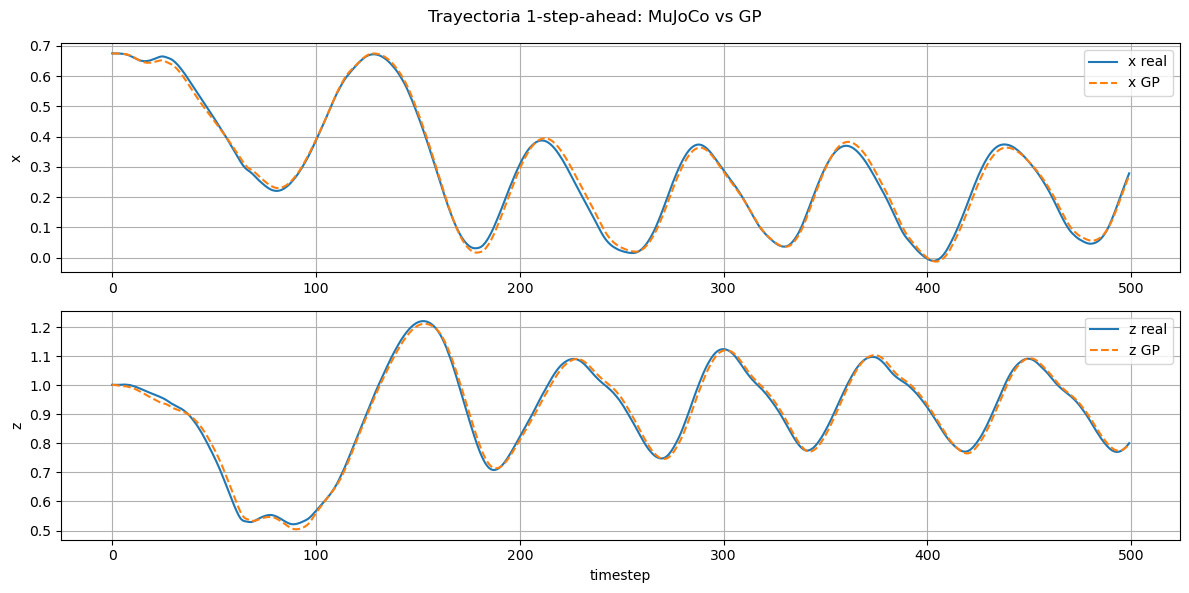

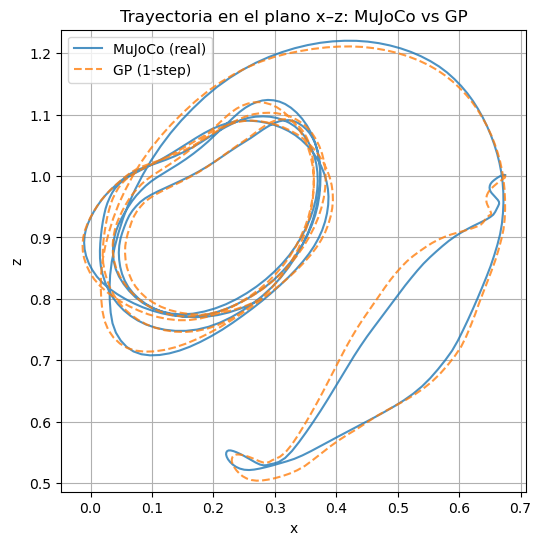

In [84]:
# Elegimos una secuencia continua de índices
t0 = 0
T = 500
X_seq = X[t0:t0+T]
Y_seq_true = Y[t0:t0+T]

Y_seq_pred = np.zeros_like(Y_seq_true)
for i in range(Y_seq_true.shape[1]):
    Y_seq_pred[:, i] = gps[i].predict(X_seq)

# Reconstruimos el estado siguiente
s_seq      = states[t0:t0+T]        # s_t
s_seq_true = states[t0+1:t0+T+1]    # s_{t+1} real
s_seq_pred = s_seq + Y_seq_pred     # s_{t+1} predicho

time = np.arange(T)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(time, s_seq_true[:,0], label="x real")
plt.plot(time, s_seq_pred[:,0], '--', label="x GP")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_seq_true[:,1], label="z real")
plt.plot(time, s_seq_pred[:,1], '--', label="z GP")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Trayectoria 1-step-ahead: MuJoCo vs GP")
plt.tight_layout()
plt.show()




plt.figure(figsize=(6,6))

# Trayectoria real (MuJoCo)
plt.plot(s_seq_true[:, 0],  # x
         s_seq_true[:, 1],  # z
         label="MuJoCo (real)", alpha=0.8)

# Trayectoria predicha por el GP (1-step-ahead)
plt.plot(s_seq_pred[:, 0],  # x
         s_seq_pred[:, 1],  # z
         '--', label="GP (1-step)", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: MuJoCo vs GP")
plt.legend()
plt.grid(True)
plt.axis('equal')   # para que las escalas de x y z no se deformen
plt.show()



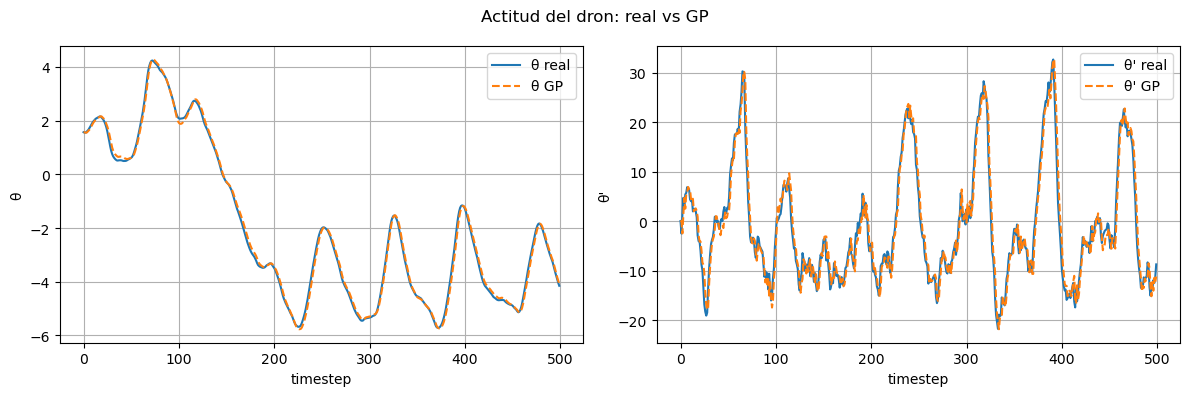

In [85]:

# ==============================================
# 5️⃣ Visualización de actitudes (θ y θ') real vs GP
# ==============================================

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, s_seq_true[:,4], label="θ real")
plt.plot(time, s_seq_pred[:,4], '--', label="θ GP")
plt.xlabel("timestep")
plt.ylabel("θ")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, s_seq_true[:,5], label="θ' real")
plt.plot(time, s_seq_pred[:,5], '--', label="θ' GP")
plt.xlabel("timestep")
plt.ylabel("θ'")
plt.grid(True)
plt.legend()

plt.suptitle("Actitud del dron: real vs GP")
plt.tight_layout()
plt.show()


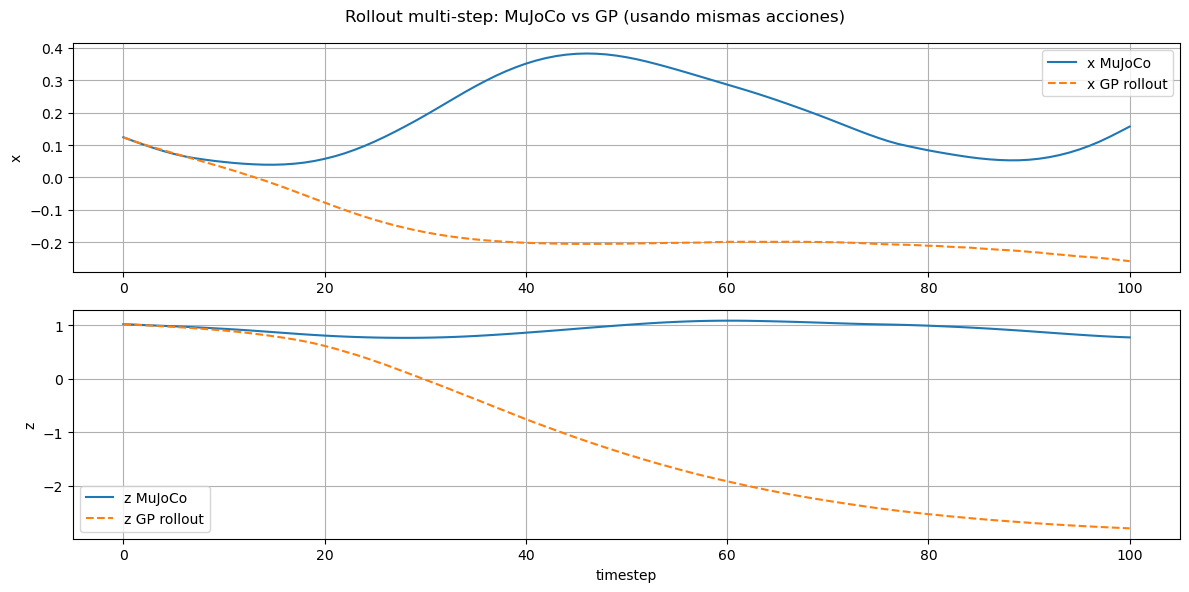

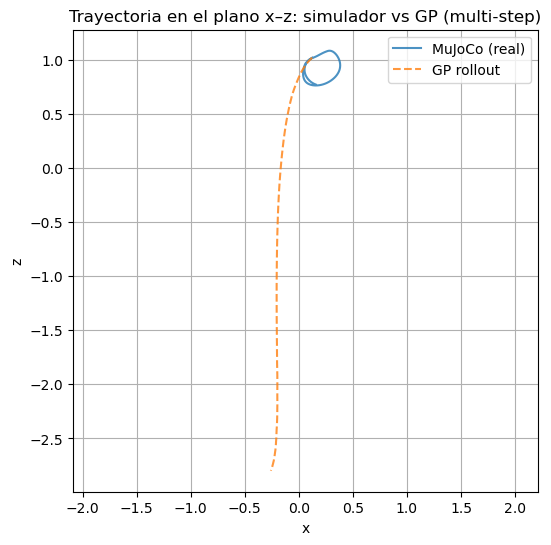

In [86]:
# ===============================================
# 5️⃣ Rollout multi-step usando el modelo GP
# ===============================================

t0 = 1000
T = 100

s_true_traj = states[t0:t0+T+1]       # s_t ... s_{t+T}
a_traj      = actions[t0:t0+T]        # a_t ... a_{t+T-1}

# Rollout del GP
s_gp = [s_true_traj[0].copy()]        # empezamos en s_t0 real
s    = s_true_traj[0].copy()

for k in range(T):
    s_k   = s
    a_k   = a_traj[k]
    x_in  = np.hstack([s_k, a_k]).reshape(1, -1)

    # predecimos Δs
    delta_pred = np.array([gp.predict(x_in)[0] for gp in gps])
    s          = s_k + delta_pred
    s_gp.append(s.copy())

s_gp = np.array(s_gp)                 # shape (T+1, dim_s)

time = np.arange(T+1)


plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, s_true_traj[:,0], label="x MuJoCo")
plt.plot(time, s_gp[:,0], '--', label="x GP rollout")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_true_traj[:,1], label="z MuJoCo")
plt.plot(time, s_gp[:,1], '--', label="z GP rollout")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Rollout multi-step: MuJoCo vs GP (usando mismas acciones)")
plt.tight_layout()
plt.show()


# Visualización de la trayectoria en el plano x–z

plt.figure(figsize=(6,6))

plt.plot(s_true_traj[:,0], s_true_traj[:,1],
         label="MuJoCo (real)", alpha=0.8)

plt.plot(s_gp[:,0], s_gp[:,1],
         '--', label="GP rollout", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: simulador vs GP (multi-step)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


#  MPPI Controller

In [65]:
# ==============================================
# 6️⃣ Helper functions para control MPPI
# ==============================================

import numpy as np

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
act_dim   = 2   # [u_left, u_right]


def predict_next_gp(s, a, gps):
    """
    s: estado actual (6,)
    a: acción actual (2,)
    gps: lista de 6 modelos GP, cada uno predice una componente de Δs
    devuelve: s_next (6,)
    """
    x = np.hstack([s, a]).reshape(1, -1)  # (1, 8)
    delta = np.zeros(state_dim)
    for i, gp in enumerate(gps):
        delta[i] = gp.predict(x)[0]
    return s + delta


In [ ]:
# ==============================================
# 7️⃣ Control MPPI usando el modelo GP
# ===============================================

def cost_function(
    s, a,
    goal=np.array([0.0, 1.0, 0, 0, 1.57, 0]),
    weights=None
):
    """
    s = [x, z, x_dot, z_dot, theta, theta_dot]
    a = [u1, u2]
    """
    if weights is None:
        weights = dict(
            x_pos=0.0,
            z_pos=3.0,
            x_vel=0.5,
            z_vel=1.0,
            theta=0.0,
            theta_dot=1.0,
            ctrl_effort=0.1,
            ctrl_asym=0.05,
        )

    x_err        = s[0] - goal[0]
    z_err        = s[1] - goal[1]
    x_vel_err    = s[2]
    z_vel_err    = s[3]
    theta_err    = s[4] - goal[4]
    theta_dot_err = s[5]

    ctrl_effort  = np.linalg.norm(a - np.array([1.0, 1.0]))
    ctrl_asym    = np.abs(a[0] - a[1])

    cost = (
        weights["x_pos"]      * x_err**2
        + weights["z_pos"]    * z_err**2
        + weights["x_vel"]    * x_vel_err**2
        + weights["z_vel"]    * z_vel_err**2
        + weights["theta"]    * theta_err**2
        + weights["theta_dot"]* theta_dot_err**2
        + weights["ctrl_effort"] * ctrl_effort**2
        + weights["ctrl_asym"]   * ctrl_asym**2
    )
    return cost


def mppi_control(
    s0,
    u_mean,
    gps,
    goal,
    weights,
    N=80,
    H=20,
    lambda_=1.0,
    sigma_u=0.2
):
    """
    s0:    estado actual (6,)
    u_mean: secuencia nominal (H, 2)
    gps:   lista de GPs
    goal:  estado objetivo
    weights: pesos de costo
    """
    noise   = np.random.randn(N, H, 2) * sigma_u
    costs   = np.zeros(N)
    actions = np.zeros((N, H, 2))

    for n in range(N):
        s = np.copy(s0)
        cost = 0.0
        for t in range(H):
            u_t = np.clip(u_mean[t] + noise[n, t], u_min, u_max)
            s = predict_next_gp(s, u_t, gps)
            cost += cost_function(s, u_t, goal, weights)
            actions[n, t] = u_t
        costs[n] = cost

    # Softmin (importancia)
    beta = np.min(costs)
    w = np.exp(-(costs - beta) / lambda_)
    w /= np.sum(w)

    # Actualizar secuencia nominal
    for t in range(H):
        u_mean[t] = np.sum(w[:, None] * actions[:, t, :], axis=0)
    u_mean = np.clip(u_mean, u_min, u_max)

    # Receding horizon
    u_opt = u_mean[0].copy()
    u_mean[:-1] = u_mean[1:]
    u_mean[-1]  = u_mean[-2]

    return u_opt, u_mean # acción óptima y secuencia actualizada



In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import mujoco as mj

# =====================================================
# 0️⃣ Parámetros MPPI y objetivo
# =====================================================

H = 10         # pasos de predicción
N = 100          # rollouts (muestras)
lambda_ = 1.0
sigma_u = 0.2

u_min = np.array([0.0, 0.0])
u_max = np.array([2.0, 2.0])
u_init = np.array([1.0, 1.0])

goal = np.array([0.0, 1.0, 0, 0, 0, 0])

weights_custom = dict(
    x_pos=0.5,  z_pos=4.0,
    x_vel=0.5,  z_vel=1.0,
    theta=0.5,  theta_dot=0.5,
    ctrl_effort=0.1, ctrl_asym=0.05
)

T = 500   # pasos de control / frames

width, height = 640, 480

# Para guardar resultados
traj_s, traj_u, traj_cost = [], [], []
frames = []

# =====================================================
# 1️⃣ Context manager del Renderer (se auto-cierra)
# =====================================================

with mj.Renderer(model, height=height, width=width) as renderer:
    # Cámara
    cam = mj.MjvCamera()
    mj.mjv_defaultCamera(cam)

    # Ajusta estos valores (idealmente los que encontraste en tu test)
    cam.lookat   = np.array([0.3, 0.0, 0.8])
    cam.distance = 3.0
    cam.elevation = -20.0
    cam.azimuth   = 90.0

    # Reset simulador
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    prev_theta = None
    s, prev_theta = get_state_from_sensors(data, prev_theta)

    u_mean = np.tile(u_init, (H, 1))

    # 🔁 Loop de control + simulación + render
    for t in tqdm(range(T)):
        # --- MPPI: acción óptima usando el GP como modelo interno ---
        u, u_mean = mppi_control(
            s0     = s,
            u_mean = u_mean,
            gps    = gps,
            goal   = goal,
            weights= weights_custom,
            N      = N,
            H      = H,
            lambda_= lambda_,
            sigma_u= sigma_u
        )

        # --- Aplicar acción en MuJoCo ---
        data.ctrl[:] = u
        mj.mj_step(model, data)

        # --- Nuevo estado real ---
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # --- Log para análisis ---
        traj_s.append(s_next)
        traj_u.append(u)
        traj_cost.append(cost_function(s, u, goal, weights_custom))
        s = s_next.copy()

        # --- Renderizar frame ---
        renderer.update_scene(data, cam)
        rgb = renderer.render()
        frames.append(rgb.copy())

# 💡 Aquí ya se llamó automáticamente a renderer.close()

traj_s = np.array(traj_s)
traj_u = np.array(traj_u)
traj_cost = np.array(traj_cost)



100%|██████████| 500/500 [39:47<00:00,  4.78s/it]


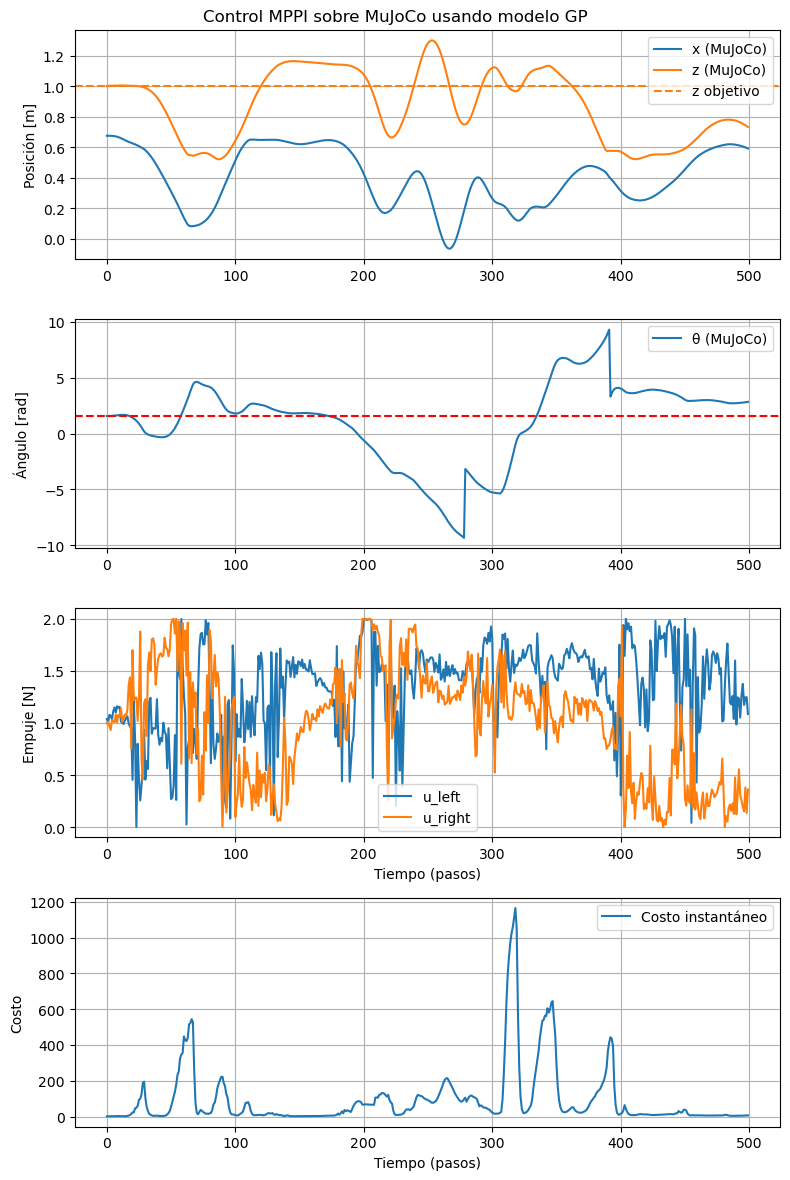

In [88]:
# =====================================================
# 2️⃣ Gráficos de estado / acción / costo
# =====================================================

fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# Posición
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color ='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color ='C1')
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# Ángulo
axes[1].plot(traj_s[:,4], label="θ (MuJoCo)")
axes[1].axhline(np.pi/2, color='r', linestyle='--')
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# Control
axes[2].plot(traj_u[:,0], label="u_left")
axes[2].plot(traj_u[:,1], label="u_right")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# Costo
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP")
plt.tight_layout()
plt.show()

# =====================================================
# 3️⃣ Animación tipo Pendulum-v1
# =====================================================

fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
plt.close()

HTML(ani.to_html5_video())